<img src = "https://github.com/VeryFatBoy/notebooks/blob/main/common/images/img_github_singlestore-jupyter_featured_2.png?raw=true">

<div id="singlestore-header" style="display: flex; background-color: rgba(235, 249, 245, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/browser.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">Using SingleStore as a Geospatial Database</h1>
    </div>
</div>

In [3]:
!pip cache purge --quiet

In [4]:
!pip install networkx --quiet
!pip install folium --quiet

In [5]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import folium

from folium import plugins
from singlestoredb import notebook as nb

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Action Required</b></p>
        <p>Select the database from the drop-down menu at the top of this notebook. It updates the <b>connection_url</b> which is used by SQLAlchemy to make connections to the selected database.</p>
    </div>
</div>

In [6]:
from sqlalchemy import *

db_connection = create_engine(connection_url)

In [7]:
connections_df = pd.read_sql(
    "SELECT * FROM london_connections",
    con = db_connection
)

In [8]:
lines_df = pd.read_sql(
    "SELECT * FROM london_lines",
    con = db_connection
)

In [9]:
stations_df = pd.read_sql(
    "SELECT * FROM london_stations",
    con = db_connection
)

In [10]:
graph = nx.Graph()

for station_id, station in stations_df.iterrows():
    graph.add_node(
        station["name"],
        lon = station["longitude"],
        lat = station["latitude"],
        s_id = station["id"]
    )

for connection_id, connection in connections_df.iterrows():
    station1_name = stations_df.loc[stations_df["id"] == connection["station1"], "name"].item()
    station2_name = stations_df.loc[stations_df["id"] == connection["station2"], "name"].item()
    graph.add_edge(
        station1_name,
        station2_name,
        time = connection["time"],
        line = connection["line"]
    )

In [11]:
len(graph.nodes()), len(graph.edges())

(302, 349)

In [12]:
node_positions = {node[0]: (node[1]["lon"], node[1]["lat"]) for node in graph.nodes(data = True)}

In [13]:
dict(list(node_positions.items())[0:5])

{'Becontree': (0.127, 51.5403),
 'Blackfriars': (-0.1031, 51.512),
 'Bounds Green': (-0.1243, 51.6071),
 'Caledonian Road': (-0.1188, 51.5481),
 'Canary Wharf': (-0.0209, 51.5051)}

In [15]:
edge_lines = [edge[2]["line"] for edge in graph.edges(data = True)]

In [16]:
edge_lines[0:5]

[4, 4, 4, 3, 10]

In [17]:
edge_colours = [lines_df.loc[lines_df["line"] == line, "colour"].iloc[0] for line in edge_lines]

In [18]:
edge_colours[0:5]

['#00782A', '#00782A', '#00782A', '#FFD300', '#003688']

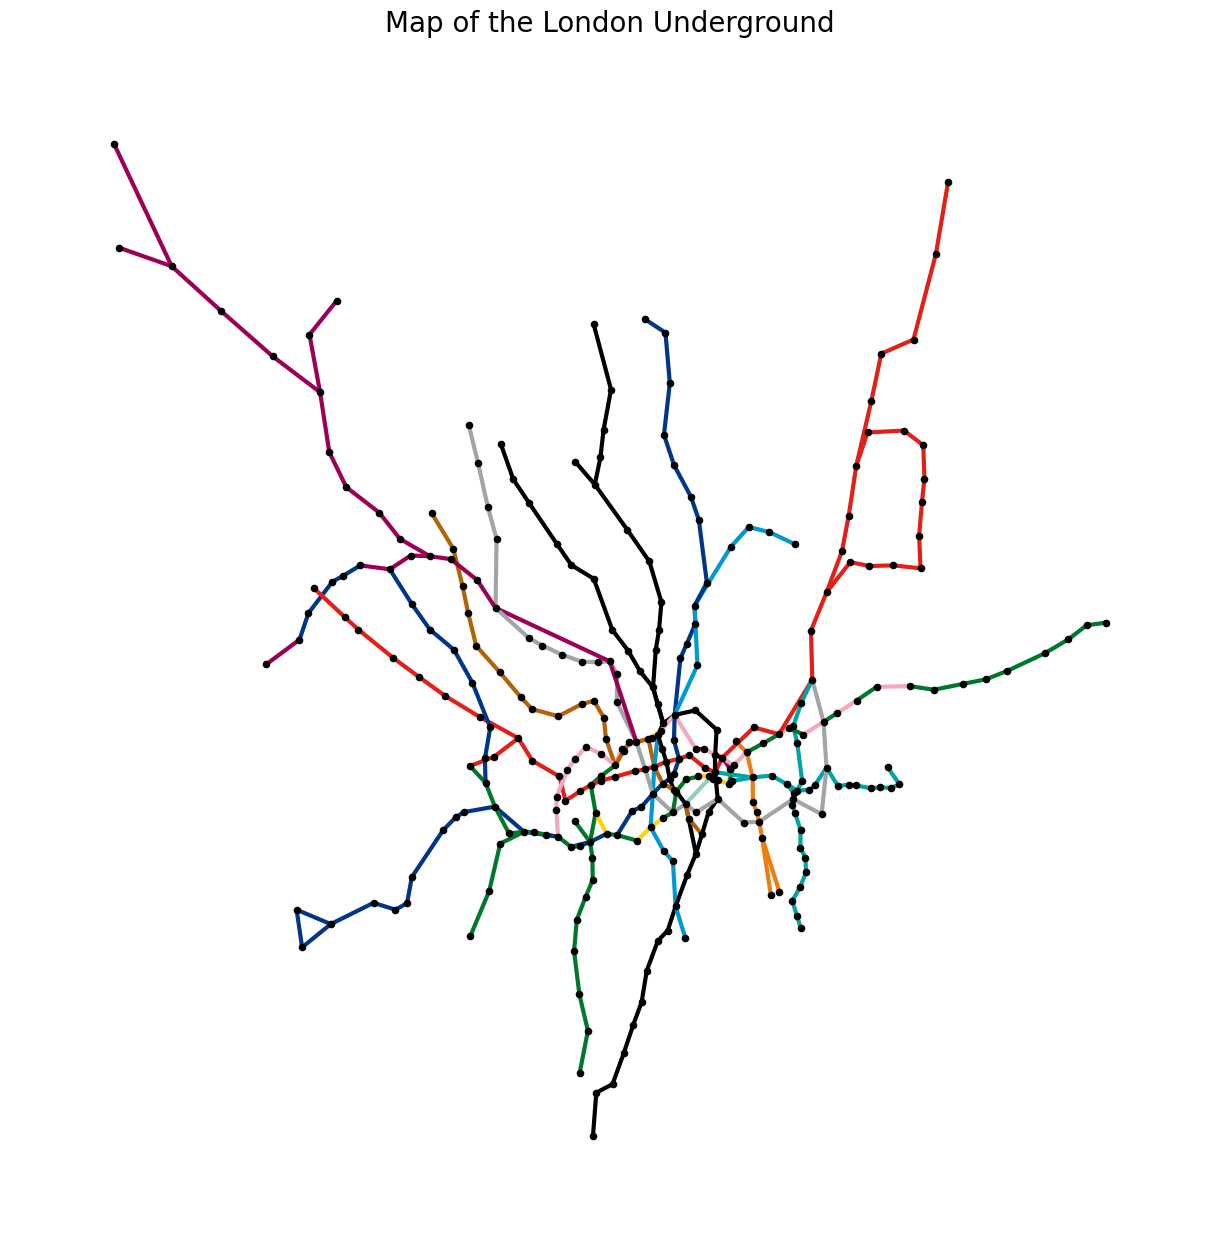

In [19]:
plt.figure(figsize = (12, 12))

nx.draw(
    graph,
    pos = node_positions,
    edge_color = edge_colours,
    node_size = 20,
    node_color = "black",
    width = 3
)

plt.title("Map of the London Underground", size = 20)
plt.show()

In [20]:
data = []

lons, lats = map(nx.get_node_attributes, [graph, graph], ["lon", "lat"])
lines, times = map(nx.get_edge_attributes, [graph, graph], ["line", "time"])

for edge in list(graph.edges()):
    data.append({
        "station_from": edge[0],
        "lon_from": lons.get(edge[0]),
        "lat_from": lats.get(edge[0]),
        "station_to": edge[1],
        "lon_to": lons.get(edge[1]),
        "lat_to": lats.get(edge[1]),
        "line": lines.get(edge),
        "time": times.get(edge)
    })

network_df = pd.DataFrame(data)

In [21]:
network_df.head()

,station_from,lon_from,lat_from,station_to,lon_to,lat_to,line,time
0,Becontree,0.1270,51.5403,Dagenham Heathway,0.1469,51.5417,4,3
1,Becontree,0.1270,51.5403,Upney,0.1014,51.5385,4,2
2,Blackfriars,-0.1031,51.5120,Temple,-0.1141,51.5111,4,2
3,Blackfriars,-0.1031,51.5120,Mansion House,-0.0940,51.5122,3,1
4,Bounds Green,-0.1243,51.6071,Arnos Grove,-0.1331,51.6164,10,3


In [22]:
network_df = pd.merge(network_df, lines_df, how = "left", on = "line")

In [23]:
network_df.head()

,station_from,lon_from,lat_from,station_to,lon_to,lat_to,line,time,name,colour,stripe
0,Becontree,0.1270,51.5403,Dagenham Heathway,0.1469,51.5417,4,3,District Line,#00782A,None
1,Becontree,0.1270,51.5403,Upney,0.1014,51.5385,4,2,District Line,#00782A,None
2,Blackfriars,-0.1031,51.5120,Temple,-0.1141,51.5111,4,2,District Line,#00782A,None
3,Blackfriars,-0.1031,51.5120,Mansion House,-0.0940,51.5122,3,1,Circle Line,#FFD300,None
4,Bounds Green,-0.1243,51.6071,Arnos Grove,-0.1331,51.6164,10,3,Piccadilly Line,#003688,None


In [24]:
London = [51.509865, -0.118092]

m = folium.Map(
    location = London,
    zoom_start = 12
)

for i in range(0, len(stations_df)):
    folium.Marker(
        location = [stations_df.iloc[i]["latitude"], stations_df.iloc[i]["longitude"]],
        popup = stations_df.iloc[i]["name"],
    ).add_to(m)

for i in range(0, len(network_df)):
    folium.PolyLine(
        locations = [
            (network_df.iloc[i]["lat_from"], network_df.iloc[i]["lon_from"]),
            (network_df.iloc[i]["lat_to"], network_df.iloc[i]["lon_to"])
        ],
        color = network_df.iloc[i]["colour"],
        weight = 3,
        opacity = 1
    ).add_to(m)

plugins.Fullscreen(
    position = "topright",
    title = "Fullscreen",
    title_cancel = "Exit",
    force_separate_button = True
).add_to(m)

html_content = m._repr_html_()

In [25]:
with nb.stage.open("lu_map.html", "w") as st:
    st.write(html_content)

In [26]:
shortest_path = nx.shortest_path(graph, "Oxford Circus", "Canary Wharf", weight = "time")

In [27]:
shortest_path

['Oxford Circus',
 'Tottenham Court Road',
 'Holborn',
 'Chancery Lane',
 "St. Paul's",
 'Bank',
 'Shadwell',
 'Wapping',
 'Rotherhithe',
 'Canada Water',
 'Canary Wharf']

In [28]:
shortest_path_df = pd.DataFrame({"name" : shortest_path})

In [29]:
merged_df = pd.merge(shortest_path_df, stations_df, how = "left", on = "name")

In [30]:
merged_df

,name,id,latitude,longitude,zone,total_lines,rail,geometry
0,Oxford Circus,192,51.5150,-0.1415,1.0,3,0,POINT(-0.14149996 51.51500003)
1,Tottenham Court Road,259,51.5165,-0.1310,1.0,2,0,POINT(-0.13099998 51.51649997)
2,Holborn,126,51.5174,-0.1200,1.0,2,0,POINT(-0.11999998 51.51740003)
3,Chancery Lane,48,51.5185,-0.1111,1.0,1,0,POINT(-0.11109996 51.51850004)
4,St. Paul's,250,51.5146,-0.0973,1.0,1,0,POINT(-0.09729999 51.51459999)
5,Bank,13,51.5133,-0.0886,1.0,4,0,POINT(-0.08859997 51.51330000)
6,Shadwell,225,51.5117,-0.0560,2.0,2,0,POINT(-0.05599996 51.51170000)
7,Wapping,276,51.5043,-0.0558,2.0,1,0,POINT(-0.05579999 51.50430002)
8,Rotherhithe,216,51.5010,-0.0525,2.0,1,0,POINT(-0.05249996 51.50100003)
9,Canada Water,41,51.4982,-0.0502,2.0,2,0,POINT(-0.05020000 51.49819998)


In [31]:
m = folium.Map()

sw = merged_df[["latitude", "longitude"]].min().values.tolist()
ne = merged_df[["latitude", "longitude"]].max().values.tolist()

m.fit_bounds([sw, ne])

for i in range(0, len(merged_df)):
    folium.Marker(
        location = [merged_df.iloc[i]["latitude"],merged_df.iloc[i]["longitude"]],
        popup = merged_df.iloc[i]["name"],
    ).add_to(m)

points = tuple(zip(merged_df.latitude, merged_df.longitude))

folium.PolyLine(
    points,
    color = "red",
    weight = 3,
    opacity = 1
).add_to(m)

plugins.Fullscreen(
    position = "topright",
    title = "Fullscreen",
    title_cancel = "Exit",
    force_separate_button = True
).add_to(m)

html_content = m._repr_html_()

In [32]:
with nb.stage.open("shortest_route_map.html", "w") as st:
    st.write(html_content)